In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import pickle


In [4]:
x = pickle.load(open('x.pickle','rb'))
y = np.array([(pickle.load(open('y.pickle','rb')))])

p = pickle.load(open('p.pickle','rb'))
q = np.array([(pickle.load(open('q.pickle','rb')))])
print(q)

[[1 0 0 1 0 1 1 0 0 1 1 0]]


In [5]:
m_train = x.shape[0]
m_test = p.shape[0]
num_px = x.shape[1]
print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("train_set_x shape:" + str(x.shape))


Number of training examples: m_train = 103
Number of testing examples: m_test = 12
Height/Width of each image: num_px = 80
train_set_x shape:(103, 80, 80, 1)


In [6]:
train_set_x_flatten = x.reshape(x.shape[0], -1).T
test_set_x_flatten = p.reshape(p.shape[0], -1).T
print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(q.shape))

train_set_x_flatten shape: (6400, 103)
train_set_y shape: (1, 103)
test_set_x_flatten shape: (6400, 12)
test_set_y shape: (1, 12)


In [7]:
train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.

In [8]:
def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """

    s = 1./(1+np.exp(-z))
    
    return s


In [9]:
def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """
    
    w = np.zeros((dim,1))
    b = 0

    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b

In [10]:
def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    """
    
    m = X.shape[1]
    
    # FORWARD PROPAGATION (FROM X TO COST)
    A = sigmoid(np.dot(w.T, X) + b)                                           # compute activation
    cost = -(np.dot(Y, (np.log(A).T)) + np.dot(1-Y, (np.log(1-A)).T))/m       # compute cost
    
    # BACKWARD PROPAGATION (TO FIND GRAD)
    dw = np.dot(X, (A-Y).T)/m
    db = np.sum(A-Y, axis = 1)/m

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [11]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    We basically need to write down two steps and iterate through them:
        1) Calculate the cost and the gradient for the current parameters, using propagate().
        2) Update the parameters using gradient descent rule for w and b.
    """
    
    costs = []
    
    for i in range(num_iterations):
                
        # Cost and gradient calculation
        grads, cost = propagate(w, b, X, Y)
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule
        w = w - learning_rate*dw
        b = b - learning_rate*db
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
        # Print the cost every 100 training iterations
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [12]:
def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    
    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    A = sigmoid(np.dot(w.T, X) + b)
    
    for i in range(A.shape[1]):
        
        # Convert probabilities A[0,i] to actual predictions p[0,i]
        if A[0, i] > 0.5:
            Y_prediction[0, i] = 1
        else:
            Y_prediction[0, i] = 0
    
    #assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

In [26]:
def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    """
    Builds the logistic regression model by calling the function we have implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    
    
    # initialize parameters with zeros
    w, b = initialize_with_zeros(X_train.shape[0])

    # Gradient descent
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # Predict test/train set examples
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

In [27]:
d = model(train_set_x, y, test_set_x, q , num_iterations = 2000, learning_rate = 0.005, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.470034
Cost after iteration 200: 0.388921
Cost after iteration 300: 0.340843
Cost after iteration 400: 0.307102
Cost after iteration 500: 0.281344
Cost after iteration 600: 0.260657
Cost after iteration 700: 0.243466
Cost after iteration 800: 0.228826
Cost after iteration 900: 0.216126
Cost after iteration 1000: 0.204951
Cost after iteration 1100: 0.195007
Cost after iteration 1200: 0.186074
Cost after iteration 1300: 0.177990
Cost after iteration 1400: 0.170626
Cost after iteration 1500: 0.163882
Cost after iteration 1600: 0.157675
Cost after iteration 1700: 0.151940
Cost after iteration 1800: 0.146621
Cost after iteration 1900: 0.141671
train accuracy: 99.02912621359224 %
test accuracy: 91.66666666666667 %


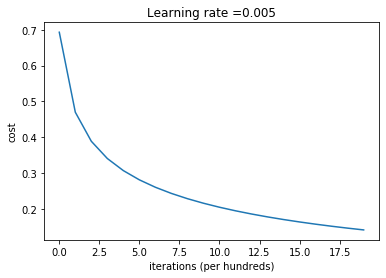

In [16]:
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

learning rate is: 0.01
train accuracy: 100.0 %
test accuracy: 91.66666666666667 %

-------------------------------------------------------

learning rate is: 0.001
train accuracy: 89.32038834951456 %
test accuracy: 91.66666666666667 %

-------------------------------------------------------

learning rate is: 0.0001
train accuracy: 83.49514563106796 %
test accuracy: 75.0 %

-------------------------------------------------------



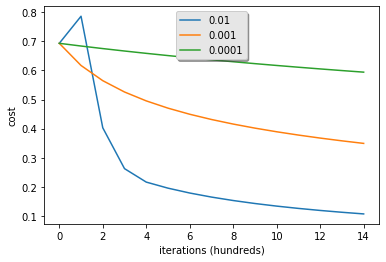

In [25]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}

for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[str(i)] = model(train_set_x, y,test_set_x,q, num_iterations = 1500, learning_rate = i, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations (hundreds)')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

In [21]:
#first test with one image
my_image = 'C:\\Users\\USER\\Desktop\\xrays database\\test_data\\tooth7.jpg'
#preprocessing the image

IMG_SIZE = 80
image = cv2.imread(my_image,cv2.IMREAD_GRAYSCALE)
def preprocessing(my_image):
    image = cv2.imread(my_image,cv2.IMREAD_GRAYSCALE)
    new_image = cv2.resize(image,(IMG_SIZE, IMG_SIZE))
    new_image_flatten = new_image.reshape((1,IMG_SIZE*IMG_SIZE)).T
    return new_image_flatten

new_image_flatten = preprocessing(my_image)
my_predicted_image = predict(d["w"], d["b"], new_image_flatten)
if np.squeeze(my_predicted_image) == 1:
    print('it is a 2 or more roots teeth')
elif np.squeeze(my_predicted_image) == 0:
    print('it is a 1 root teeth')

it is a 1 root teeth


In [22]:
#test in all datasets
for img in range(len(p)):
    new_image_flatten = p[img].reshape((1,IMG_SIZE*IMG_SIZE)).T
    my_predicted_image = predict(d["w"], d["b"], new_image_flatten)
    if np.squeeze(my_predicted_image) == 1:
        print('it is a 2 or more roots teeth')
    elif np.squeeze(my_predicted_image) == 0:
        print('it is a 1 root teeth')


it is a 2 or more roots teeth
it is a 1 root teeth
it is a 1 root teeth
it is a 2 or more roots teeth
it is a 1 root teeth
it is a 2 or more roots teeth
it is a 2 or more roots teeth
it is a 1 root teeth
it is a 1 root teeth
it is a 2 or more roots teeth
it is a 1 root teeth
it is a 1 root teeth
